# End-to-end Model MLOps Workflow with AWS SageMaker, Lambda, and API Gateway 
This notebook is an effort to learn, understand, and implement the AWS Sagemaker service to build, train, and deploy an end-to-end Machine Learning workflow along with inference usage with AWS Lambda and AWS API Gateway.

## Architecture Diagram  

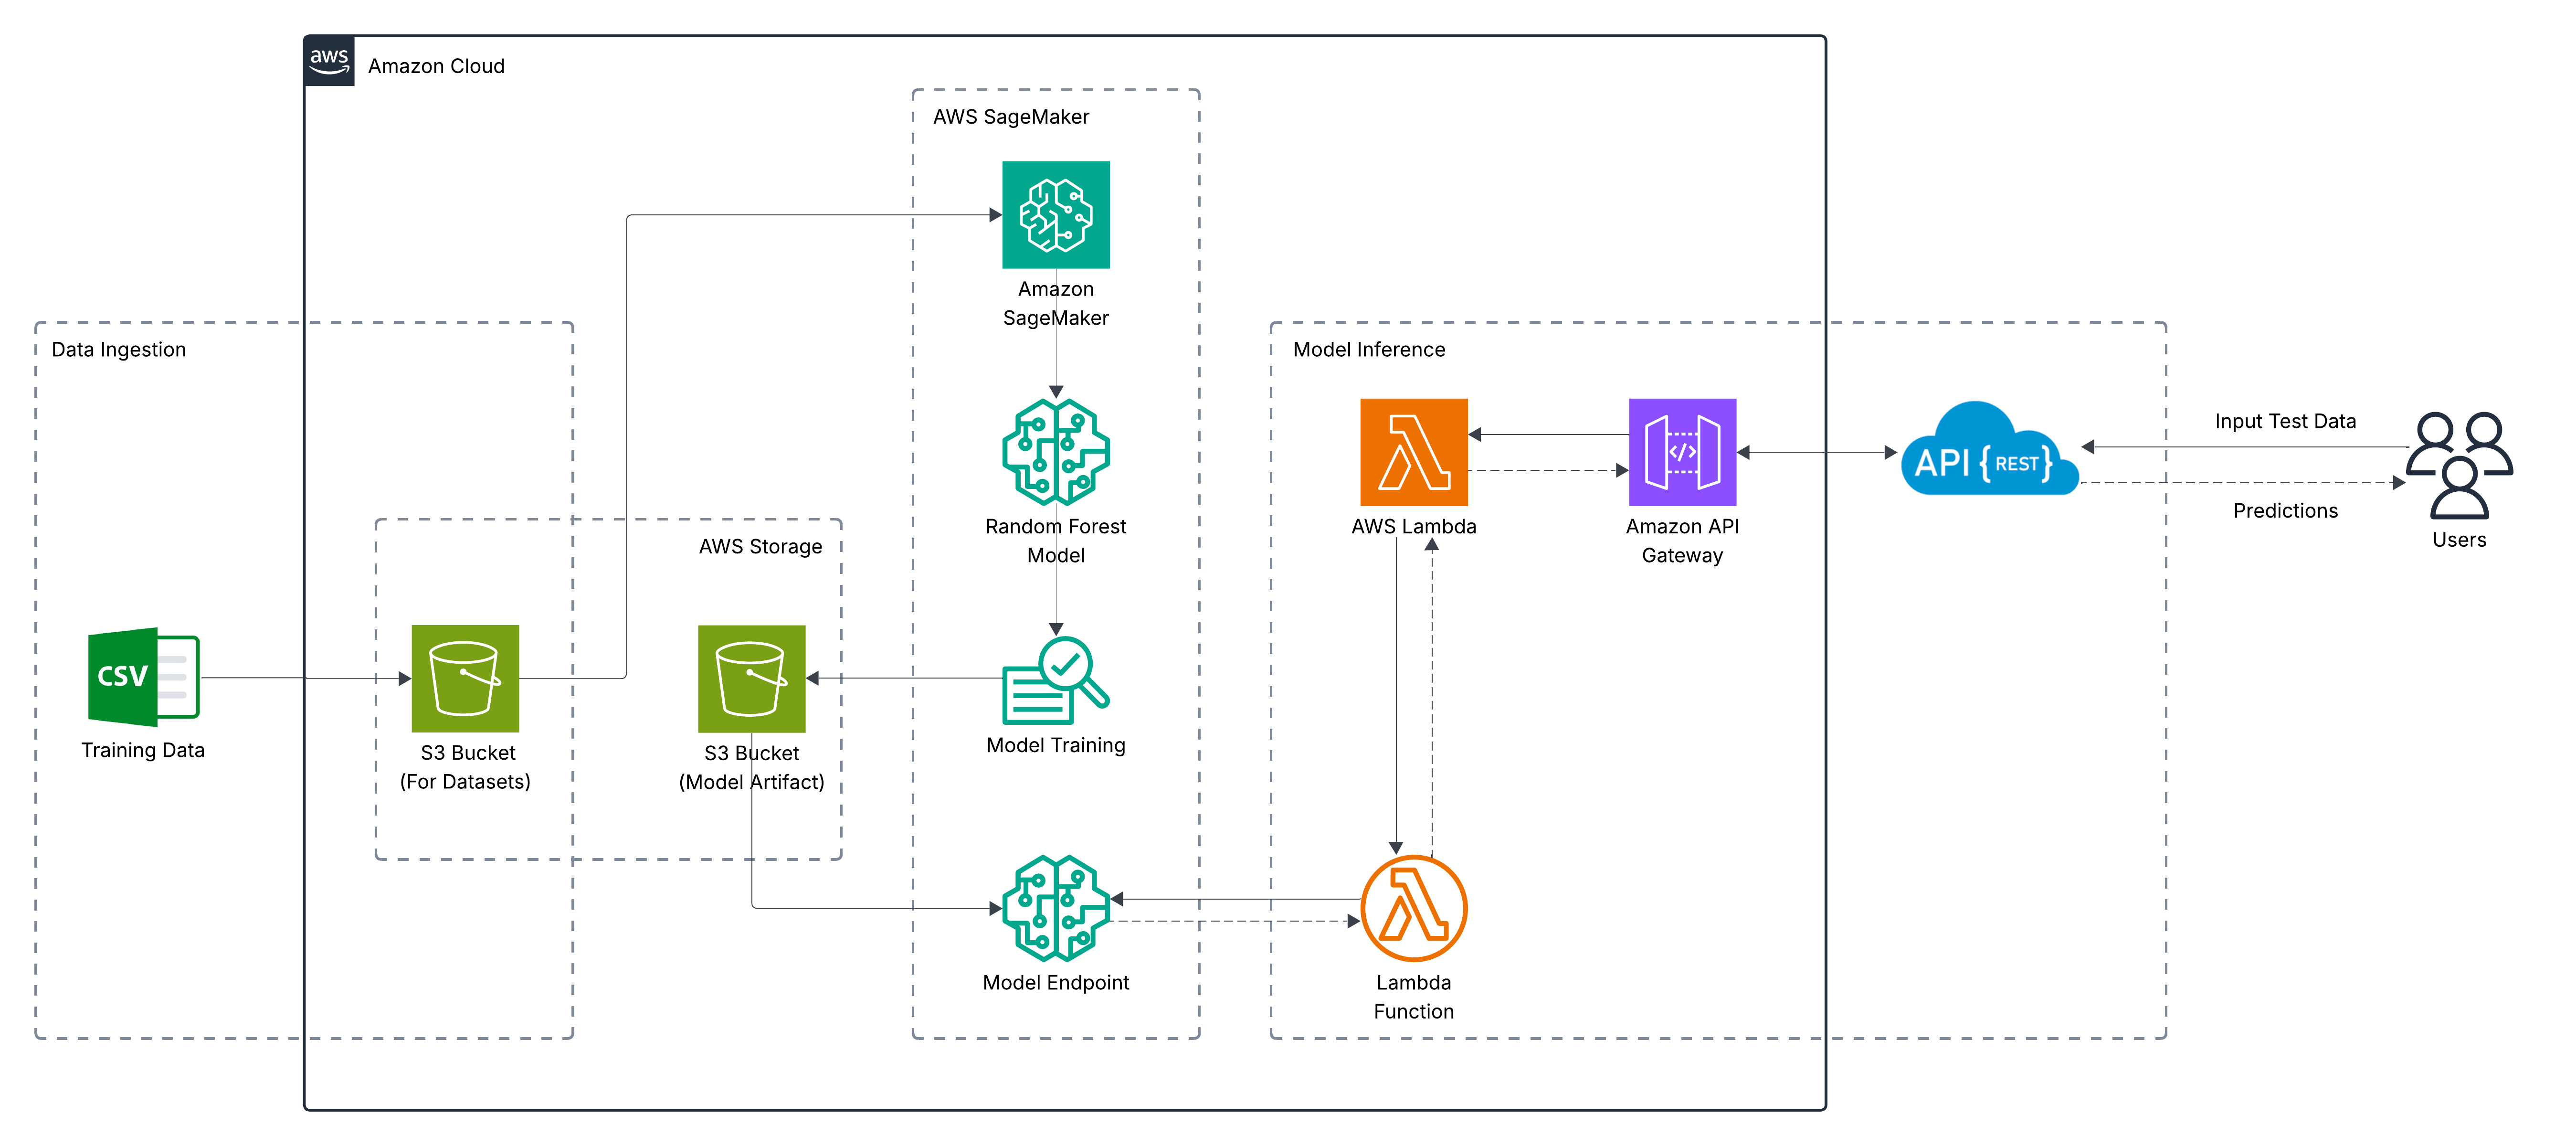   

This is the architecture that I have designed and implemented in this notebook. If it looks confusing, rest assured, I have tried my best to go deep into the explanation part throughout this notebook to make things easy to understand. Let's dive deep!

## Initializing with Libraries and S3 Setup

In [1]:
# Importing primary libraries.
import sagemaker
from sklearn.model_selection import train_test_split
import boto3
import pandas as pd
import os

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\prath\AppData\Local\sagemaker\sagemaker\config.yaml


In [2]:
# Creating a SageMaker client object using boto3.
sm_boto3 = boto3.client("sagemaker")

# Creating a SageMaker session.
sess = sagemaker.Session()
region = sess.boto_session.region_name

# Mentioning the created S3 bucket name here, it needs to be globally unique and already created. 
bucket = "sagemaker-test-user-bucket-05-31-2025" 
print("Using bucket:", bucket)

Using bucket: sagemaker-test-user-bucket-05-31-2025


## Getting the Dataset

In [3]:
# Data folder path.
data_folder_path = os.path.join(os.getcwd(), "Data")

# Dataset name.
data_file = "mob_price_classification_train.csv"

# Dataframe creation.
df = pd.read_csv(os.path.join(data_folder_path, data_file))
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


Great, now we have the dataset. Spending some time performing EDA must be a part of every project we work on and this one isn’t an exception. However, we won’t be performing a deep analysis here as this will distract us from the main topic of learning ML workflow in Sagemaker!

In [4]:
print("Dataset rows:", df.shape[0])
print("Dataset columns:", df.shape[1])

Dataset rows: 2000
Dataset columns: 21


In [5]:
# Looking at value of classes in target column.
df["price_range"].value_counts()

price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [7]:
df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


In [8]:
# Looking for missing values.
df.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

No missing values, so good for us!

In [9]:
# Separating features and labels.
features = list(df.columns)
label = features.pop(-1)

# Creating feature and target dataframes.
x = df[features]
y = df[label]

In [10]:
x.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0


In [11]:
y.head()

0    1
1    2
2    2
3    2
4    1
Name: price_range, dtype: int64

In [12]:
# Splitting the feature and target set into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.15, random_state=0)

print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)
print("y_train Shape:", y_train.shape)
print("y_test Shape:", y_test.shape)

X_train Shape: (1700, 20)
X_test Shape: (300, 20)
y_train Shape: (1700,)
y_test Shape: (300,)


In [13]:
# Combining the features and target for training & testing sets to save whole dataset as CSV (to further push into S3 bucket).
trainX = pd.DataFrame(X_train)
trainX[label] = y_train

testX = pd.DataFrame(X_test)
testX[label] = y_test

print("trainX Shape:", trainX.shape)
print("testX Shape:", testX.shape)

trainX Shape: (1700, 21)
testX Shape: (300, 21)


In [14]:
# Saving training and testing datasets to CSV files.
train_set_path = os.path.join(data_folder_path, "train-V-1.csv")
test_set_path = os.path.join(data_folder_path, "test-V-1.csv")

trainX.to_csv(train_set_path,index = False)
testX.to_csv(test_set_path, index = False)

Now this dataset needs to be uploaded to AWS S3 Bucket. This is required becasue the Sagemaker takes the datasets from S3.

## Loading Dataset to AWS S3 Bucket (Data Ingestion)

In [15]:
print("Bucket to use:", bucket)

Bucket to use: sagemaker-test-user-bucket-05-31-2025


In [16]:
# Path inside our S3 bucket (basically folder structure inside the S3 bucket).
s3_prefix = "sagemaker/mobile_price_classification/sklearncontainer"

# Uploading training dataset.
s3_train_path = sess.upload_data(
    path=train_set_path, 
    bucket=bucket, 
    key_prefix=s3_prefix
)

# Uploading testing dataset.
s3_test_path = sess.upload_data(
    path=test_set_path, 
    bucket=bucket, 
    key_prefix=s3_prefix
)

print("S3 training set path:", s3_train_path)
print("S3 testing set path:", s3_test_path)

S3 training set path: s3://sagemaker-test-user-bucket-05-31-2025/sagemaker/mobile_price_classification/sklearncontainer/train-V-1.csv
S3 testing set path: s3://sagemaker-test-user-bucket-05-31-2025/sagemaker/mobile_price_classification/sklearncontainer/test-V-1.csv


Now the training and testing datasets have been successfully uploaded to our AWS S3 bucket. This was nothing but the data ingestion phase, where we got the data, performed splits, and uploaded to S3, to make it available for the AWS Sagemaker access.

Now comes the important phase. Untill now we did everything (data exploration, ingestion, etc) in this local Jupyter Notebook. Perfect. We could've also done some more EDA, visualizations, trends analysis, basic experimentation, etc just as normally as we do for any data/ML project right here in this notebook.     
   
However, the process for actually training the model is slightly different. Once we reach the model training phase, AWS SageMaker expects us to play by its rules. Specifically, for SageMaker to deploy our custom models as endpoints, it requires a specific training script that does the following:   
- Loads the data from its source.
- Trains a single model on it.
- Saves the model and its artifacts.
- Reports its metrics.

Once this script is ready, it is fed into special estimators provided by SageMaker. They are companions for popular ML libraries such as scikit-learn, XGBoost, TensorFlow, PyTorch, etc. Using these estimators, SageMaker builds Docker containers around your script, deploying it as an endpoint to serve it at scale.

Let's look at this script first.

## Entrypoint Script

Note that the %%writefile script.py magic command in the below script converts the cell's contents into a Python script instead of running it.

In [17]:
%%writefile script.py

# Importing few required libraries.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import sklearn
import joblib
import boto3
import pathlib
from io import StringIO 
import argparse
import joblib
import os
import numpy as np
import pandas as pd

# Function to get the model for training.
def model_fn(model_dir):
    clf = joblib.load(os.path.join(model_dir, "model.joblib"))
    return clf
    
if __name__ == "__main__":

    print("\n[INFO] Extracting Arguments")
    parser = argparse.ArgumentParser()

    # Hyperparameters sent by the client are passed as command-line arguments to the script.
    # These are arguments required by the ML model. RFC in our case.
    parser.add_argument("--n_estimators", type=int, default=100)
    parser.add_argument("--random_state", type=int, default=0)

    # Data, model, and output directories.
    # These are the arguments required by Sagemaker to identify the model location, datasets locations, etc.
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="train-V-1.csv")
    parser.add_argument("--test-file", type=str, default="test-V-1.csv")

    args, _ = parser.parse_known_args()
    
    print("SKLearn Version: ", sklearn.__version__)
    print("Joblib Version: ", joblib.__version__)

    print("\n[INFO] Reading Data")
    print()
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))
    
    features = list(train_df.columns)
    label = features.pop(-1)
    
    print("Building training and testing datasets")
    print()
    X_train = train_df[features]
    X_test = test_df[features]
    y_train = train_df[label]
    y_test = test_df[label]

    print('Column order: ')
    print(features)
    print()
    
    print("\nLabel column is: ",label)
    print()
    
    print("---- SHAPE OF TRAINING DATA (85%) ----")
    print(X_train.shape)
    print(y_train.shape)
    print()
    print("---- SHAPE OF TESTING DATA (15%) ----")
    print(X_test.shape)
    print(y_test.shape)
    print()
     
    print("\n[INFO] Training RandomForest Model")
    print()
    model =  RandomForestClassifier(n_estimators=args.n_estimators, random_state=args.random_state, verbose = 3, n_jobs=-1)
    model.fit(X_train, y_train)
    
    print("\n[INFO] Predicting on Test set")
    y_pred_test = model.predict(X_test)
    test_acc = accuracy_score(y_test,y_pred_test)
    test_rep = classification_report(y_test,y_pred_test)

    print("\n[INFO] Metric Evaluation")
    print("---- METRICS RESULTS FOR TESTING DATA ----")
    print()
    print("Total Rows are: ", X_test.shape[0])
    print('[TESTING] Model Accuracy is: ', test_acc)
    print('[TESTING] Testing Report: ')
    print(test_rep)

    print("\n[INFO] Persist Model")
    model_path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, model_path)
    print("Model persisted at:", model_path)
    print()

Overwriting script.py


If you pay attention to the default values of the `model-dir`, `train` and `test` directories above (in the arguments part), you will see some environment variables. Those are taken from the [SageMaker SDK docs](https://sagemaker.readthedocs.io/en/stable/), which also provide instructions for writing such script files.

Now, we will pass the script to a SageMaker estimator object. In the context of AWS, a training job is a process where a model is trained using a specified algorithm, dataset, and computing resources provided by AWS SageMaker. Unlike training on a local machine or notebook, this job runs in the cloud on scalable infrastructure, allowing for more computational power, faster processing, and the ability to handle larger datasets.

## SageMaker Training

In [18]:
# Specifyong AWS role.
role = "arn:aws:iam::192771710845:role/service-role/AmazonSageMaker-ExecutionRole-20250531T135436"

In [19]:
# Now this is actual code that will run inside Sagemaker.
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="script.py",
    #role="arn:aws:iam::192771710845:user/sagemaker-test-user",
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="RFC-custom-sklearn",
    hyperparameters={
        "n_estimators": 100,
        "random_state": 0,
    },
    use_spot_instances = True,
    max_wait = 7200,
    max_run = 3600
)

In [20]:
# launch training job, with asynchronous call.
sklearn_estimator.fit({"train": s3_train_path, "test": s3_test_path}, wait=True)

INFO:sagemaker:Creating training-job with name: RFC-custom-sklearn-2025-06-12-01-09-33-982


2025-06-12 01:09:47 Starting - Starting the training job...
2025-06-12 01:10:23 Downloading - Downloading input data...
2025-06-12 01:10:48 Downloading - Downloading the training image.....2025-06-12 01:11:38,333 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2025-06-12 01:11:38,338 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-06-12 01:11:38,388 sagemaker_sklearn_container.training INFO     Invoking user training script.
2025-06-12 01:11:38,560 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-06-12 01:11:38,574 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-06-12 01:11:38,588 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2025-06-12 01:11:38,597 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
    

Once we run the cell with the code above, and if there are no errors, the training begins! SageMaker downloads the necessary Docker image that lets us run scikit-learn code and executes the script.

Since our dataset is small, we got away with low-cost, low-configuration machine for training :  ml.m5.large.   

However, in other projects, we may have to deal with datasets containing millions of records or massive image datasets. In those cases, we must choose machines offering significantly more power and GPUs.  

Using these machines on demand can be very expensive. To cut down costs, Amazon offers Spot Training instances. With those instances, you can choose high-powered computing resources for a low price with a single caveat — the training won’t start immediately. Instead, SageMaker waits until the demand is low and the machine you requested is available. We already implemented this using the `use_spot_instances = True` code in the `sklearn_estimator`. Also, a point to note that, the training actually starts when you call `.fit()` part of code.

Now, after the training is finished, Sagemaker stores our model in the S3 bucket itself (a different S3 bucket). We can check & deploy it as follows:

## Model Deployment

In [21]:
# Checking the stored model path.
sklearn_estimator.latest_training_job.wait(logs="None")
artifact = sm_boto3.describe_training_job(TrainingJobName=sklearn_estimator.latest_training_job.name)["ModelArtifacts"]["S3ModelArtifacts"]

print("\nModel artifact persisted at:", artifact)


2025-06-12 01:12:02 Starting - Preparing the instances for training
2025-06-12 01:12:02 Downloading - Downloading the training image
2025-06-12 01:12:02 Training - Training image download completed. Training in progress.
2025-06-12 01:12:02 Uploading - Uploading generated training model
2025-06-12 01:12:02 Completed - Training job completed

Model artifact persisted at: s3://sagemaker-us-east-2-192771710845/RFC-custom-sklearn-2025-06-12-01-09-33-982/output/model.tar.gz


Now to deploy the model, first we need to access the instance of our model. We'll use the `SKLearnModel` class, which is used for already-trained models. It requires the S3 location where the artifacts are stored and the script used to train it.

In [22]:
# Accessing the model.
from sagemaker.sklearn.model import SKLearnModel

# You can also give a custom name to your model using the "name" argument inside the `SKLearnModel()` class.
model = SKLearnModel(
    model_data=artifact,
    role=role,
    entry_point="script.py",
    framework_version=FRAMEWORK_VERSION,
)

Perfect! Now that we have the model, we can deploy it with the `.deploy()` method.

In [23]:
# Endpoint deployment. 
# You can also give a custom name to your endpoint using the "endpoint_name" argument inside the `.deploy()` method.

from dotenv import load_dotenv
load_dotenv
endpoint_name = "ml-sagemaker-demo-v1"
predictor = model.deploy(initial_instance_count=1, instance_type="ml.m5.large", endpoint_name=endpoint_name)

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2025-06-12-01-14-19-859
INFO:sagemaker:Creating endpoint-config with name ml-sagemaker-demo-v1
INFO:sagemaker:Creating endpoint with name ml-sagemaker-demo-v1


-----!

Voila! Our model endpoint has been created!

## Predictions on Test data (using endpoint)

In [24]:
# Taking first 2 rows of the test dataset.
test_sample_list = testX[features][0:2].values.tolist()
test_sample_list

[[1454.0,
  1.0,
  0.5,
  1.0,
  1.0,
  0.0,
  34.0,
  0.7,
  83.0,
  4.0,
  3.0,
  250.0,
  1033.0,
  3419.0,
  7.0,
  5.0,
  5.0,
  1.0,
  1.0,
  0.0],
 [1092.0,
  1.0,
  0.5,
  1.0,
  10.0,
  0.0,
  11.0,
  0.5,
  167.0,
  3.0,
  14.0,
  468.0,
  571.0,
  737.0,
  14.0,
  4.0,
  11.0,
  0.0,
  1.0,
  0.0]]

In [25]:
# Making predictions.
preds = predictor.predict(test_sample_list)
preds

array([3, 0], dtype=int64)

In [26]:
# Checking ground truth.
ground_truth = testX[label][0:2].values.tolist()
ground_truth

[3, 0]

Awesome! Congratulations, we just deployed our first model with AWS SageMaker!  However, here we tested our deployed endpoint using the deployed model instance `predictor` using the `.predict()` function and passing the test samples. This is Okay, but it's not how production applications would use it. In that case, the production way of doing it, is using AWS Lambda and AWS API Gateway.    

## Enter AWS Lambda & AWS API Gateway!   

**Basic Context**:   

**1.** AWS Lambda is a serverless compute service from AWS that allows you to run code without provisioning or managing servers. It enables you to execute code in response to events and automatically manages the underlying compute resources. This makes it a popular choice for serverless architectures and functions-as-a-service (FaaS) implementations.     

**2.** AWS API Gateway is a fully managed service that allows developers to create, publish, maintain, monitor, and secure RESTful and WebSocket APIs. It acts as a single entry point for accessing AWS or other web services, and data stored in the AWS Cloud. API Gateway handles tasks like routing requests, managing traffic, authorizing users, and monitoring API performance.   

**Basic Architecture**:   

The following diagram shows how the deployed model is called using serverless architecture. Starting from the client side, a client script calls an Amazon API Gateway API action and passes parameter values. API Gateway is a layer that provides the API to the client. In addition, it seals the backend so that AWS Lambda stays and runs in a protected private network. API Gateway passes the parameter values to the Lambda function. The Lambda function parses the value and sends it to the SageMaker model endpoint. The model returns the response to Lambda. The Lambda function sends it back to API Gateway. API Gateway responds to the client with the generated response  
   
  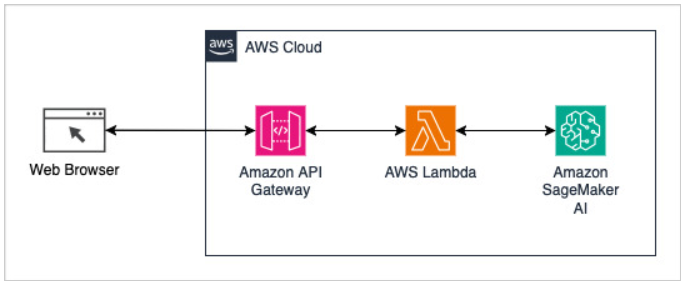 

So, let's see how we can setup AWS Lambda and AWS API Gateway.

## Setting AWS Lambda

We can do this in several ways. Either we can use the AWS Serverless Application Model (SAM) CLI and deploy the Lambda function locally (using VS-code or other editors); or we can use the AWS console and create a Lambda funtion there. The SAM method is pretty good as we can develop & keep all the lambda code locally, and even test, build, deploy it right from our local machine. Exciting! However, to keep things simple for now, we would use the AWS console itself (even for AWS API Gateway). I have performed the steps at my AWS console and pasted the screenshots below for reference. Please have a look at them.

### 1. Creating Lambda Function in AWS Console

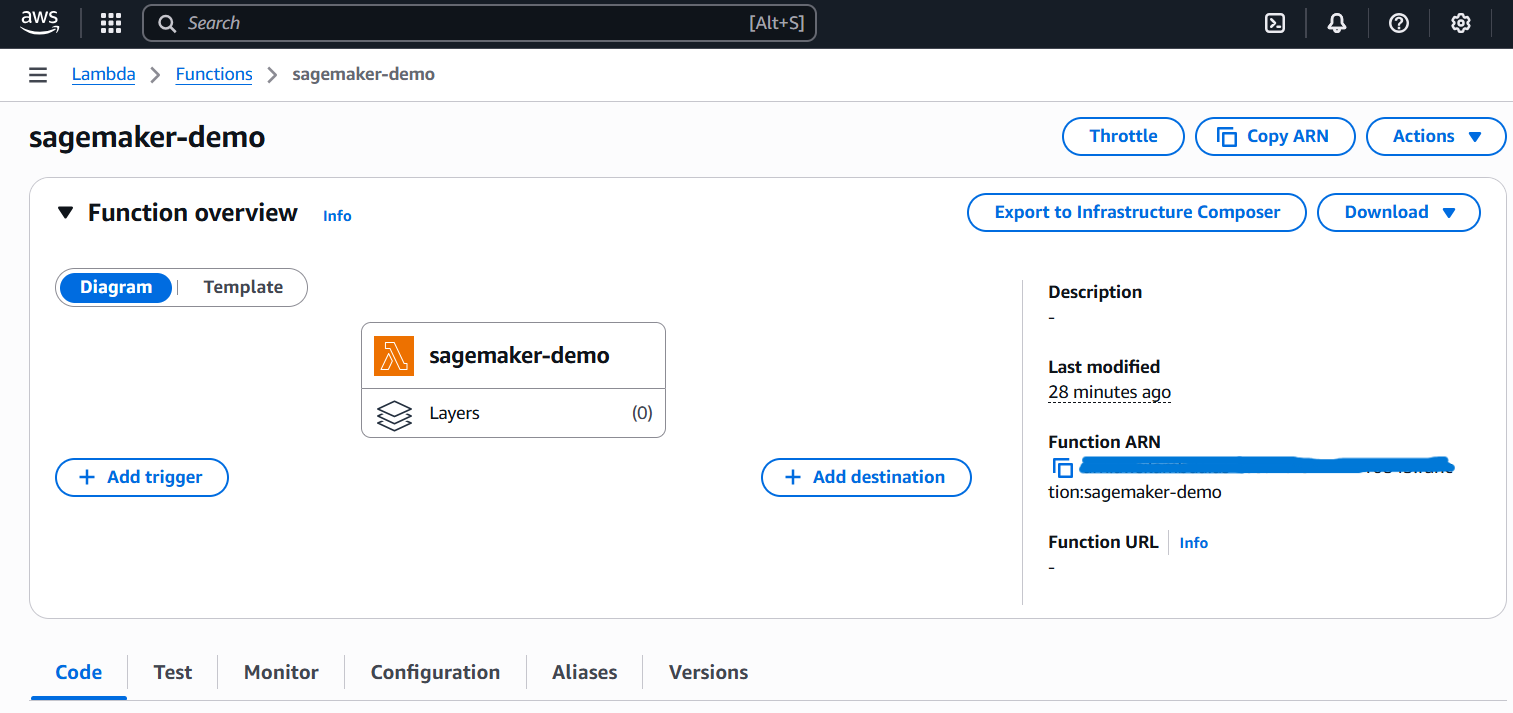

### 2. Lambda Function Code 

Then, we can write a lambda function script, that takes in the event as an API gateway input, and invokes the SageMaker endpoint, and get the model predictions as output. Note that this function script can be found in the lambda folder of this GitHub repo. Can be modified as per the requirements. 

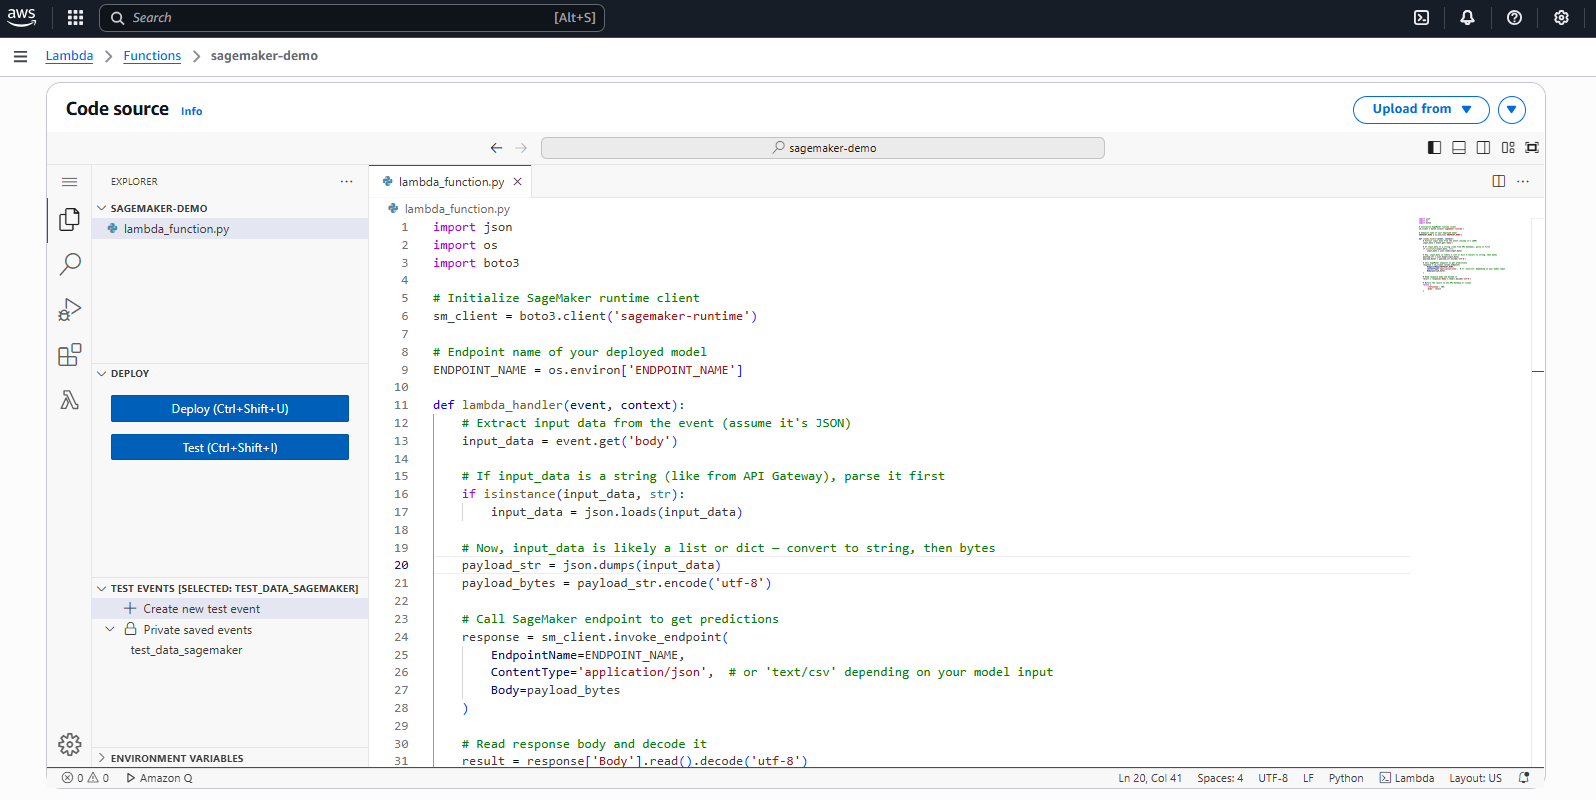  

However, before we deploy, there's 2 things we need to do:
1. Setup the Environment variables.
2. Modify the IAM role permissions (for the role associated with Lambda function) to include read access to SageMaker endpoints.

**1. Environment Variables**  

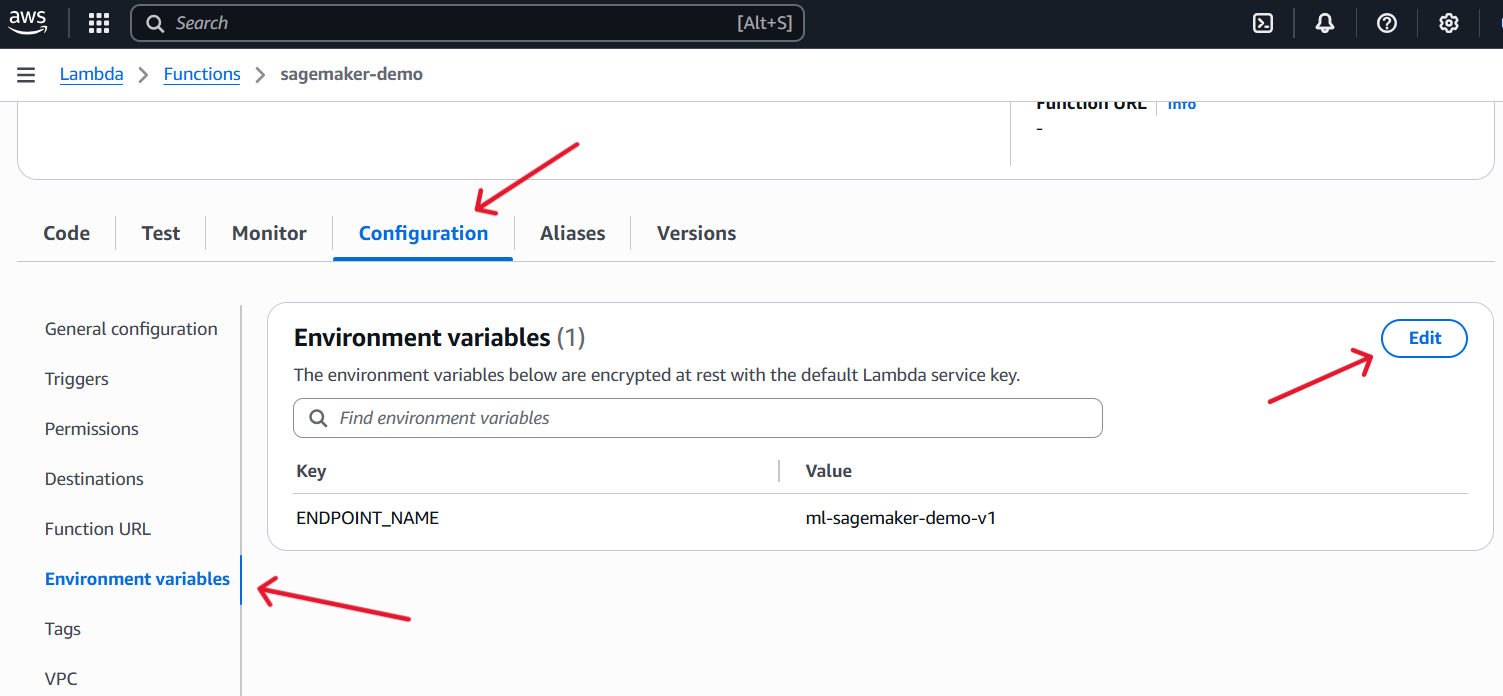  

I have created the `ENDPOINT_NAME` variable here with value `ml-sagemaker-demo-v1` as this is what we defined earlier in this notebook.  

**2. IAM Role Permission**

Access the role associated with the Lambda function.  

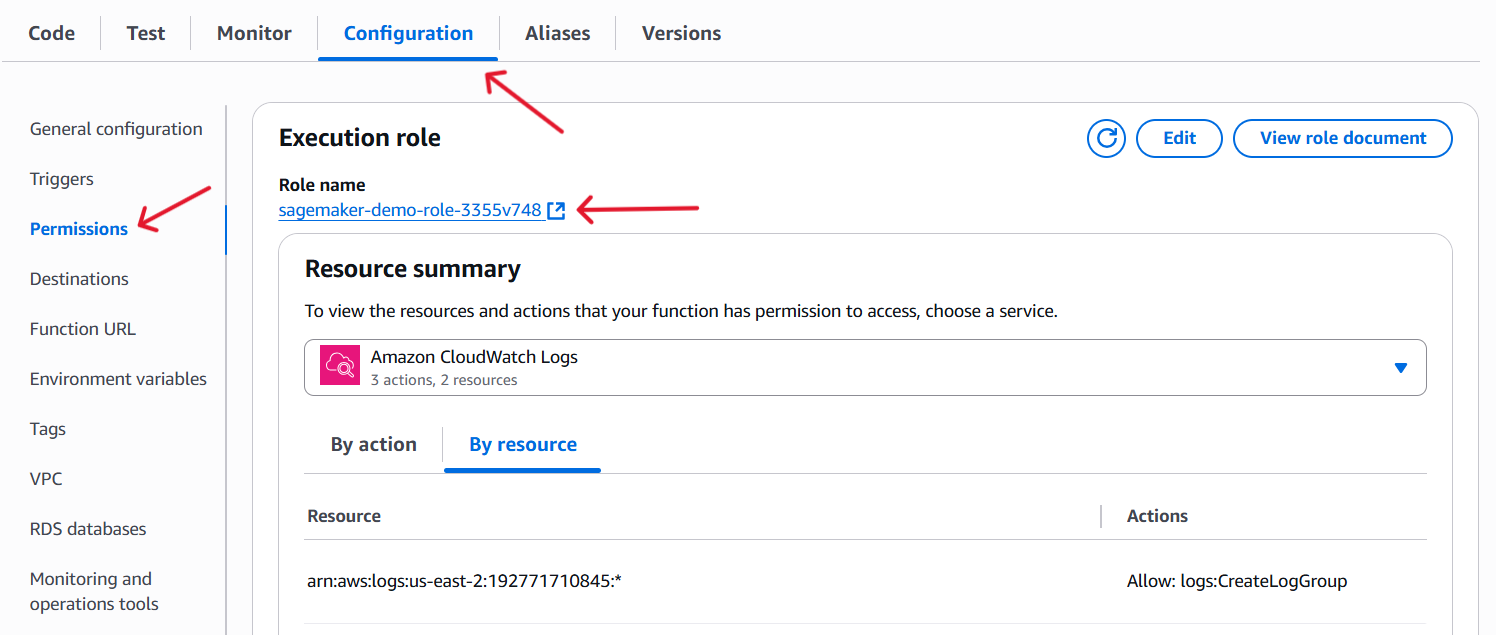  

Access the policy for that role. 

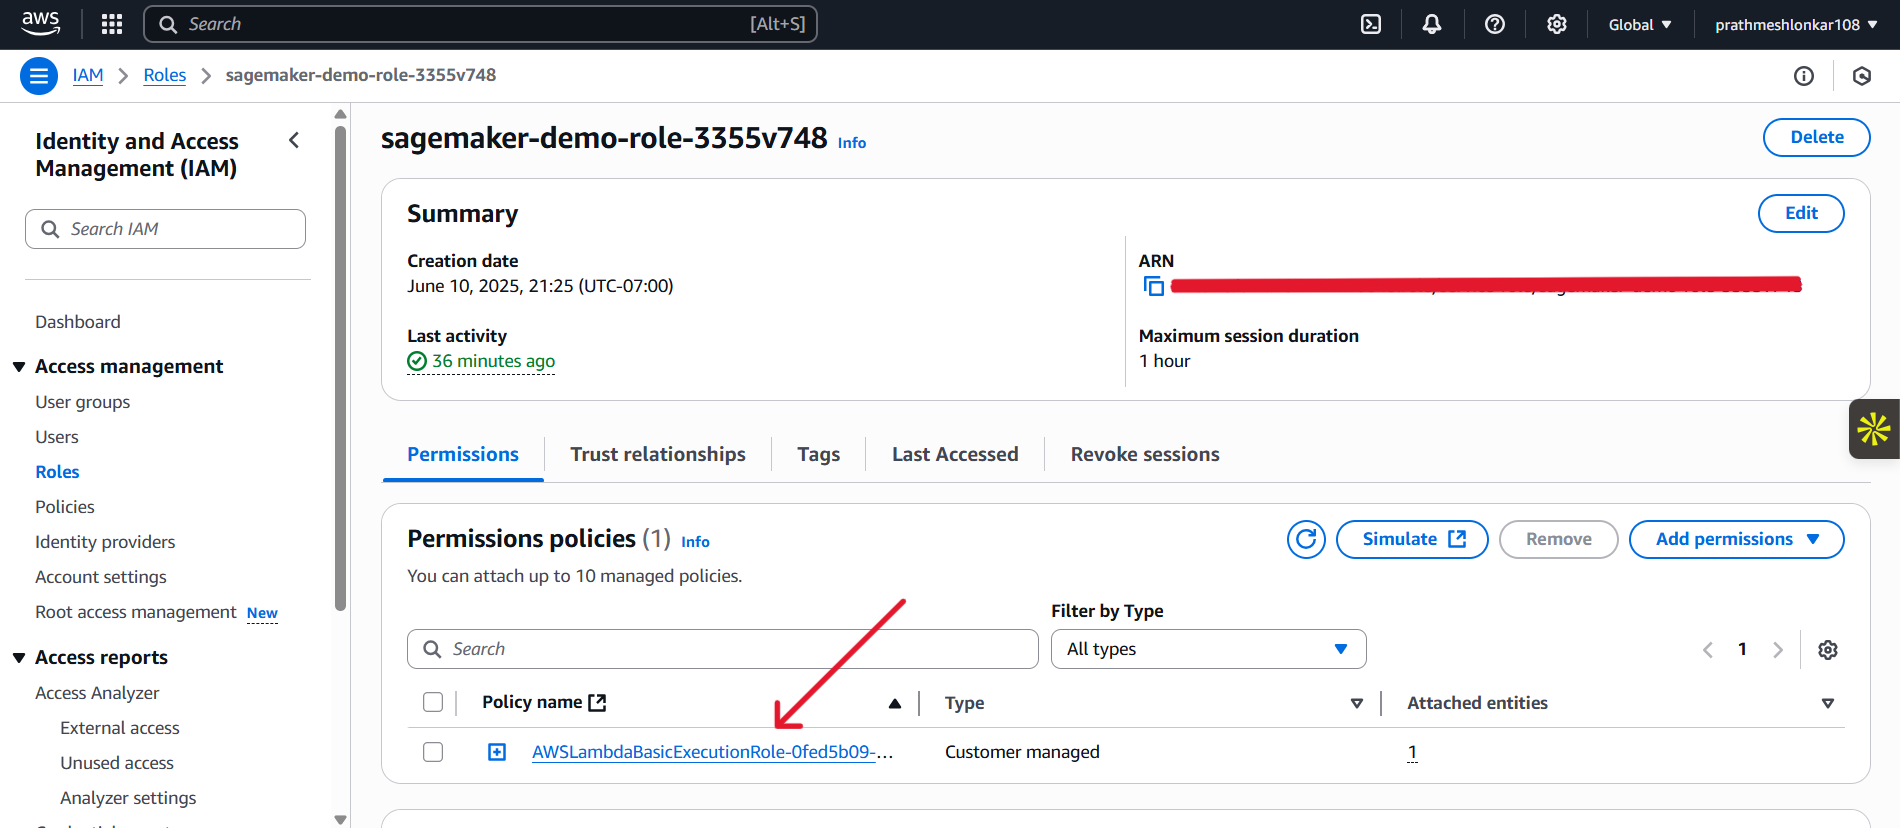  

Edit the JSON version of this policy to add the highlighted permission.  

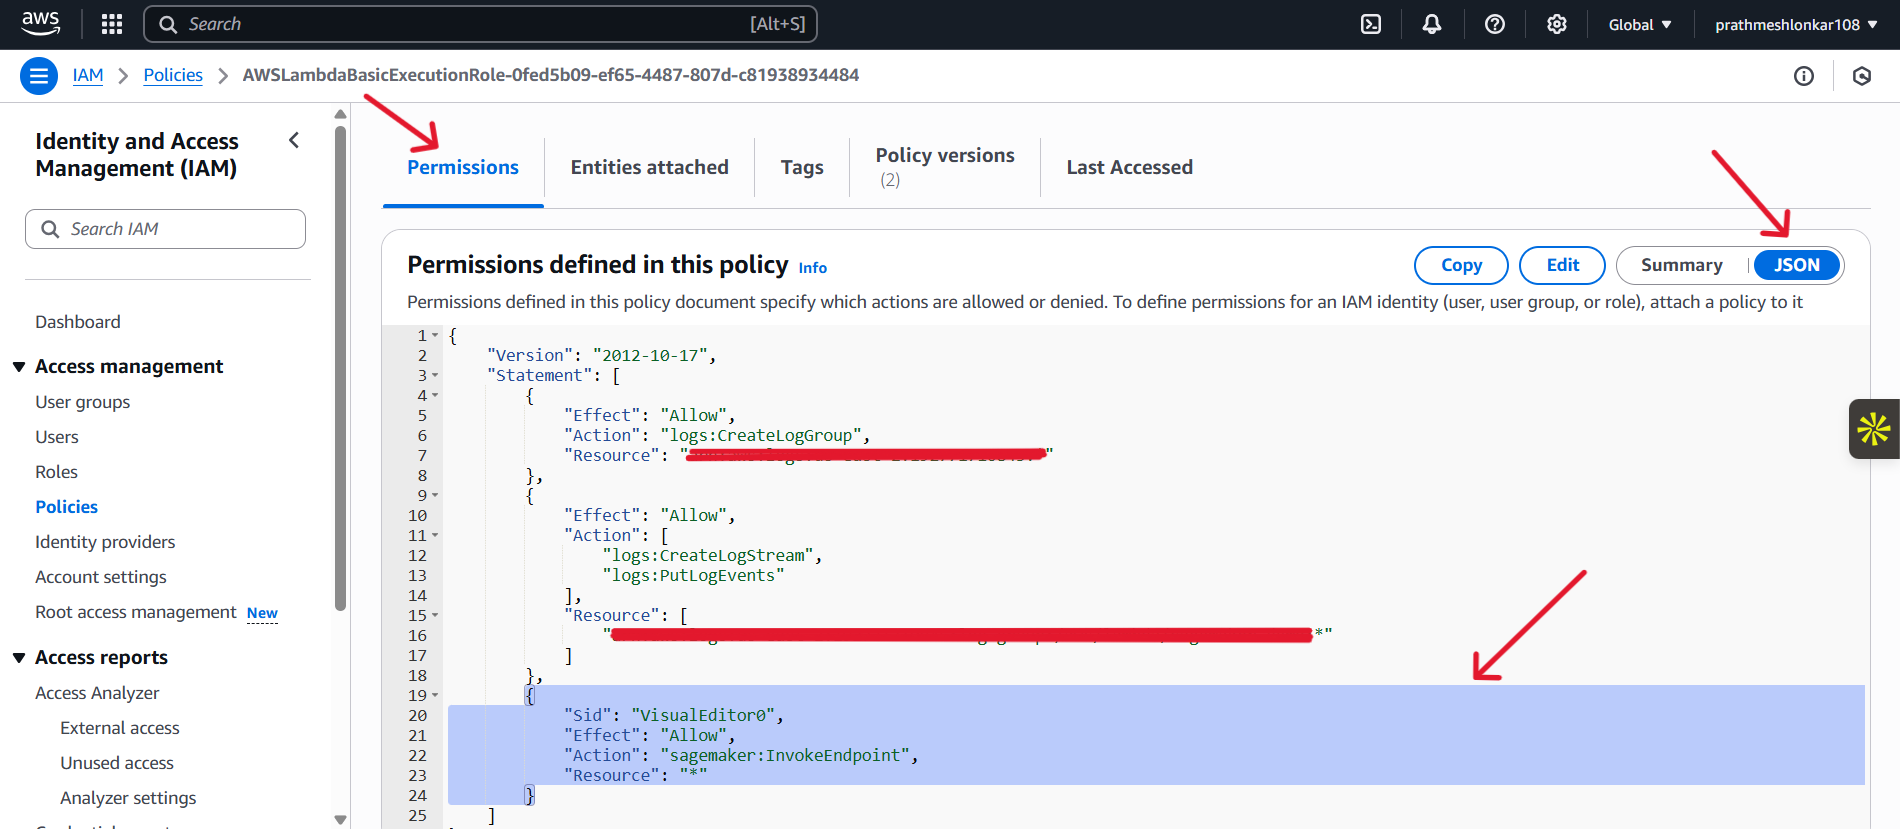

Perfect, now our Lambda function can access the SageMaker endpoint. Now we can `DEPLOY` it.   
Done? let's test it! We'll use the same test samples as we used earlier. We can use its JSON payload as given in the cell below:

**Results looking good**  

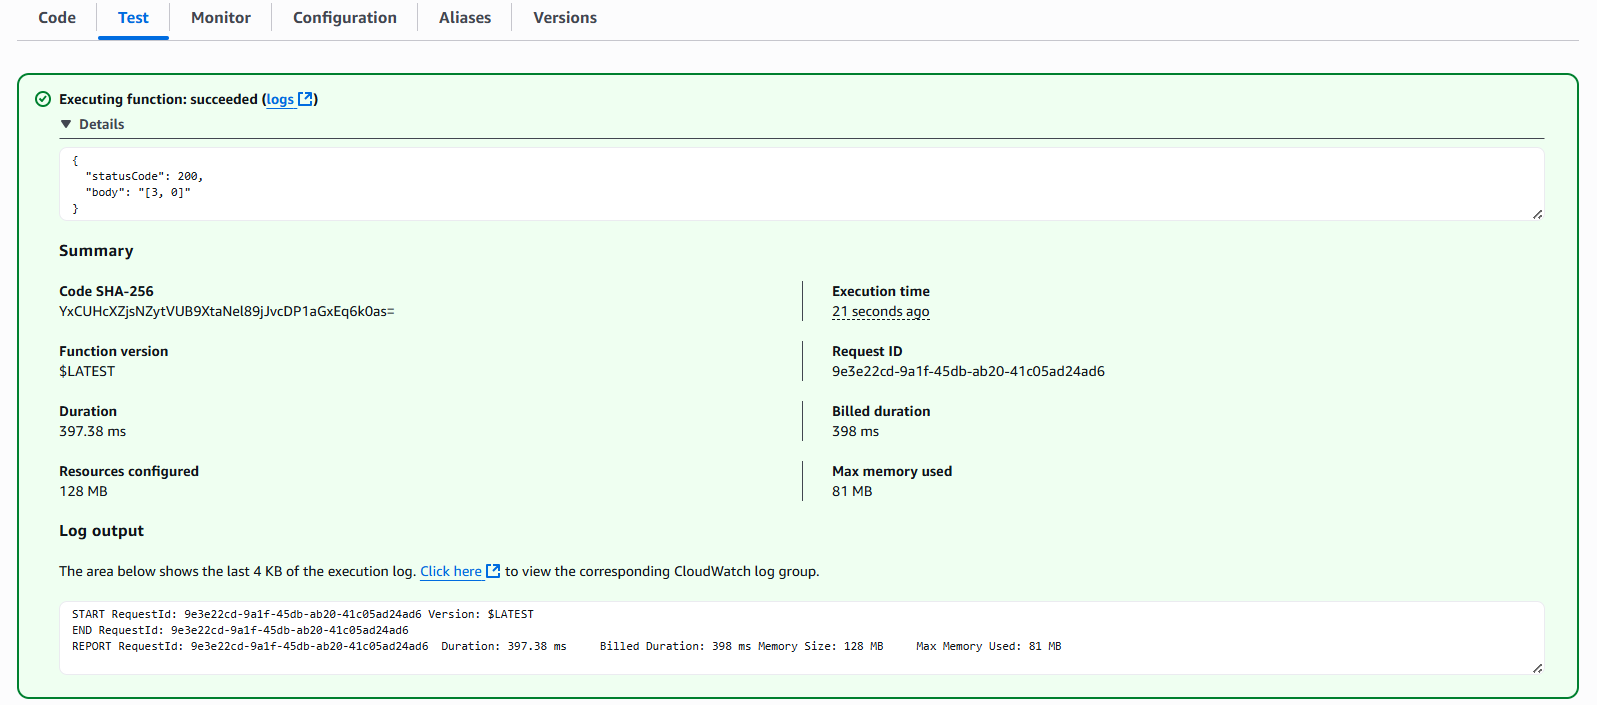

Perfect, the Lambda function works as expected. Now we can create an API Gateway.  

## Setting AWS API Gateway

We can create a new API Gateway "Resource" with "Lambda" integration type. Once that is done, we can create a new `POST` method in this resource as we need to pass the payload. This is shown below.  

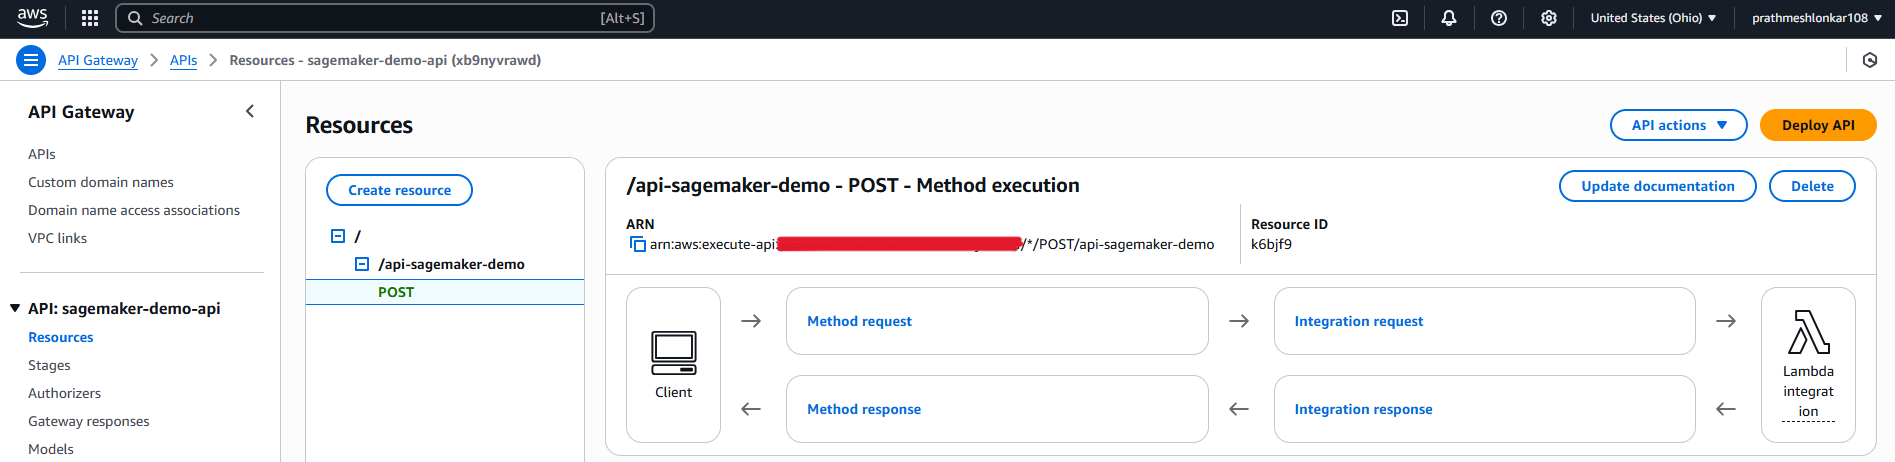   

Let's test it!  

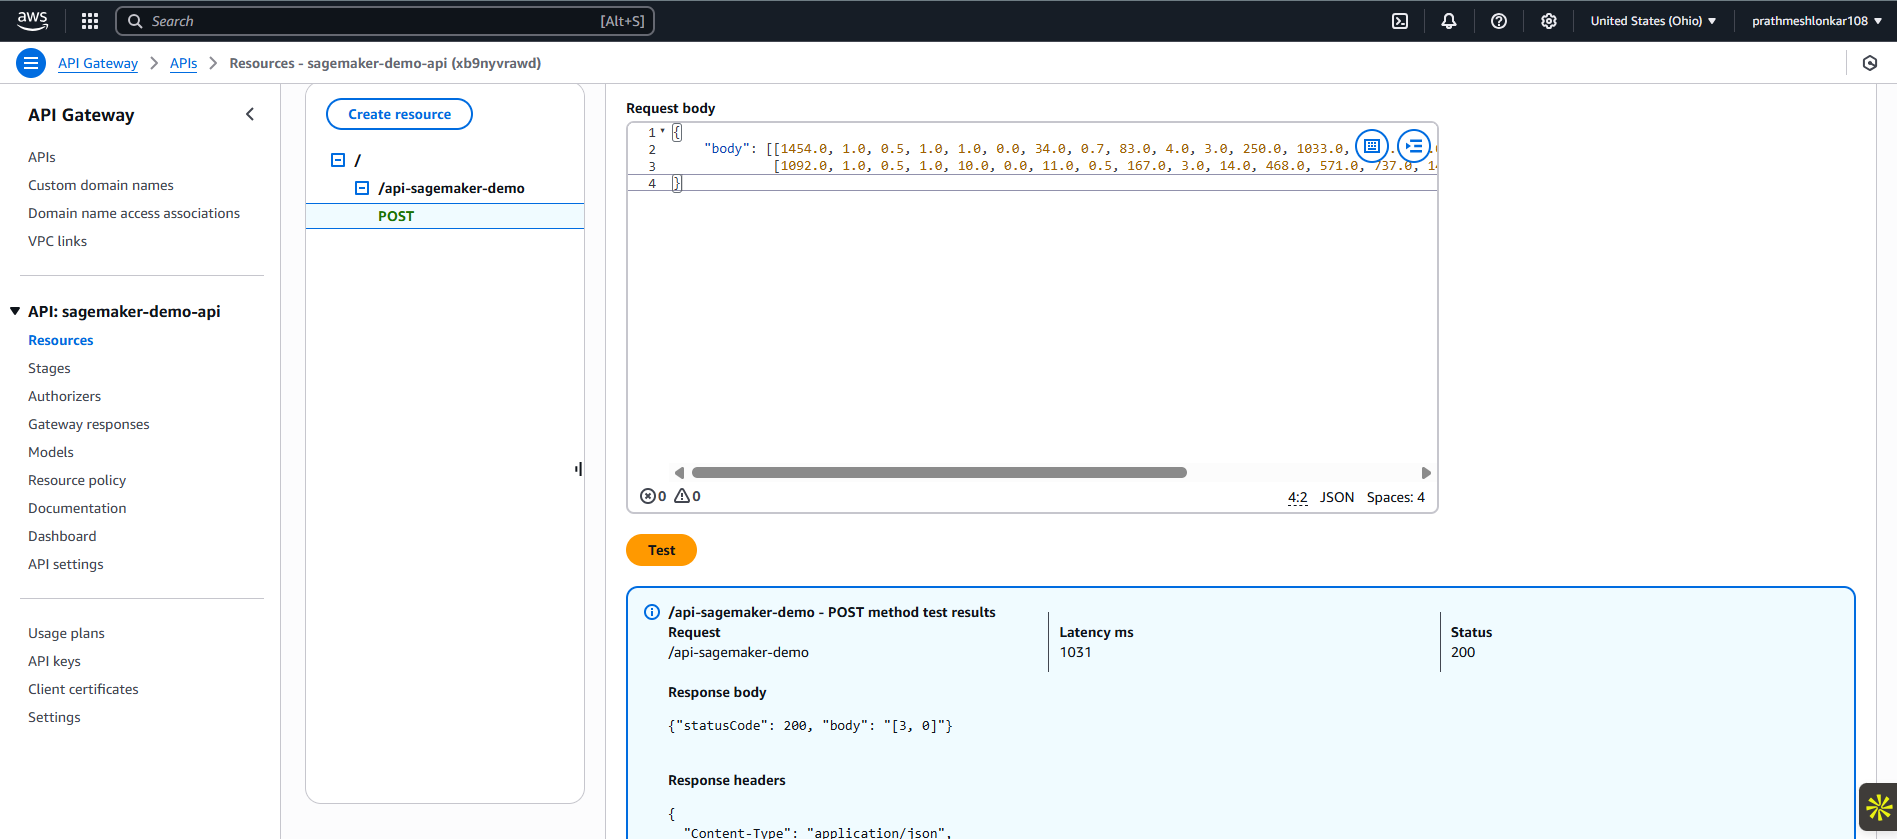

Results look good, now we can `DEPLOY` it to a new "STAGE" to get an invoking URL. 

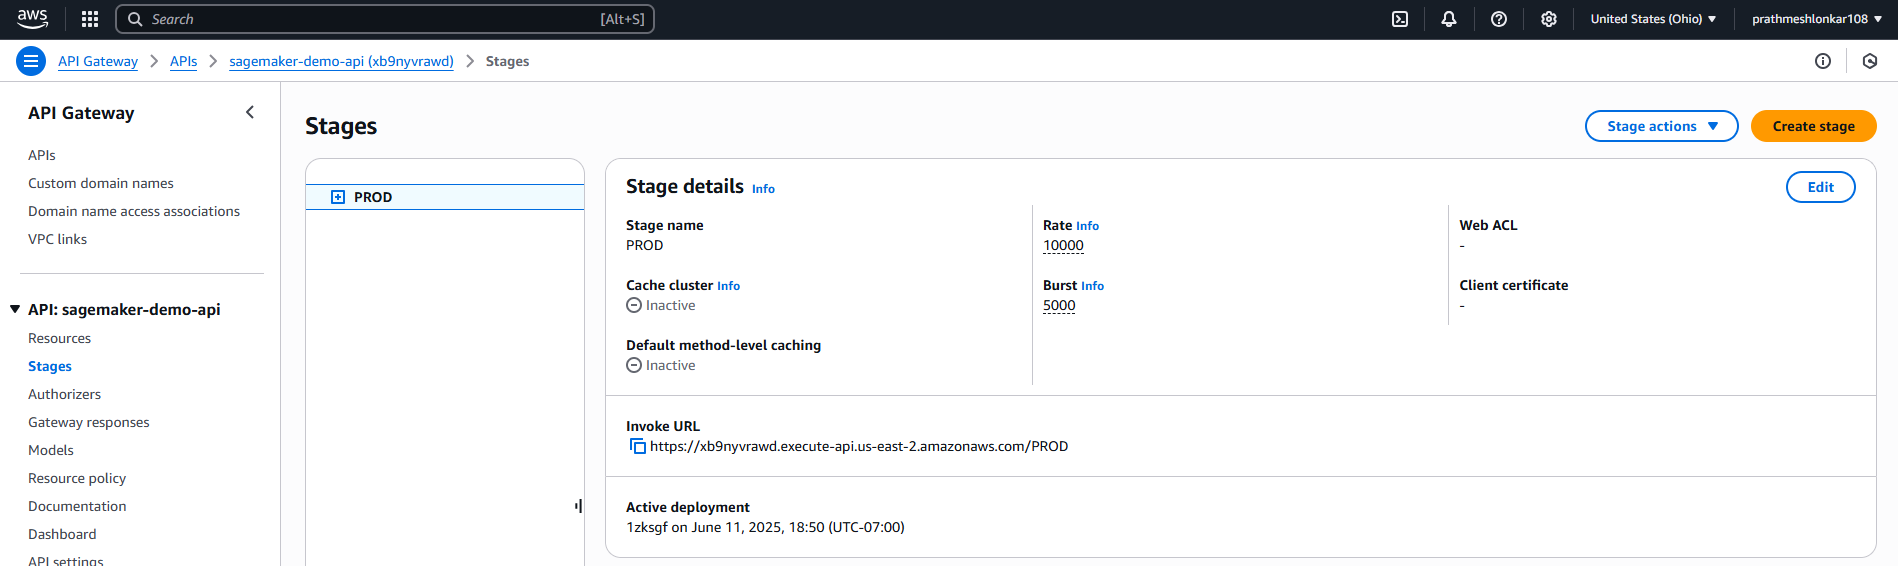

Perfect! We're done! We have the URL that we can test using the `requests` library now.

## Testing with API Gateway URL

In [32]:
import requests
import json

# API Gateway Invoke URL and Resource name.
api_url = "https://xb9nyvrawd.execute-api.us-east-2.amazonaws.com/PROD"
api_resource_name = "/api-sagemaker-demo"

# Combining to create URL endpoint.
main_url = api_url + api_resource_name

# Example input payload - must match what your Lambda expects.
payload = {
    "body": [[1454.0, 1.0, 0.5, 1.0, 1.0, 0.0, 34.0, 0.7, 83.0, 4.0, 3.0, 250.0, 1033.0, 3419.0, 7.0, 5.0, 5.0, 1.0, 1.0, 0.0],      
             [1092.0, 1.0, 0.5, 1.0, 10.0, 0.0, 11.0, 0.5, 167.0, 3.0, 14.0, 468.0, 571.0, 737.0, 14.0, 4.0, 11.0, 0.0, 1.0, 0.0]]
}

# Sending the POST request.
response = requests.post(main_url, headers={"Content-Type": "application/json"}, data=json.dumps(payload))

# Response.
print("Status code:", response.status_code)
print("Response:", response.text)


Status code: 200
Response: {"statusCode": 200, "body": "[3, 0]"}


Perfect! Congratulations, we just productionized our first model with AWS SageMaker, AWS Lambda, and AWS API Gateway! Ater this, there's a lot of scope to how we want to utilize this pipeline. We can connect a frontend (eg. streamlit) or a dashboard (eg. grafana) to showcase the prediction results. Lots to explore!

However, once we are done using this endpoint, we should not forget to delete it, as it constantly incurs new costs.

## Deleting the Deployed Model Endpoint

In [33]:
# Getting the model endpoint name.
endpoint_name = predictor.endpoint
endpoint_name

# Deleting the endpoint.
sm_boto3.delete_endpoint(EndpointName=endpoint_name)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


{'ResponseMetadata': {'RequestId': '303b5f66-6467-4438-8b44-0fb754bac751',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '303b5f66-6467-4438-8b44-0fb754bac751',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Thu, 12 Jun 2025 03:22:09 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

Perfect! We have learned how to use one of the most popular enterprise machine learning platforms:  AWS SageMaker. We’ve covered everything from building, training, and deploying ML models as endpoints using SageMaker. We've also used production methods using AWS Lambda and AWS API Gateway to use the model endpoint efficiently at scale. Cheers!

## Resources:  
1) https://sagemaker.readthedocs.io/en/stable/index.html
2) https://aws.amazon.com/sagemaker-ai/pricing/
3) https://aws.amazon.com/blogs/machine-learning/call-an-amazon-sagemaker-model-endpoint-using-amazon-api-gateway-and-aws-lambda/